In [1]:
import sys
assert sys.version_info >= (3, 5)

from collections import defaultdict
from datetime import datetime
import json
import logging
import os
from pathlib import Path
import random
import re
import sys
from typing import Dict, Tuple
import urllib
from zipfile import ZipFile

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load and preprocess data

In [2]:
!ls

20200101-20211217 ERCOT Day-Ahead Price.csv
20210101-20211213 ERCOT Day-Ahead Price.csv
20210101-20211217 ERCOT Real-time Price.csv
Realtime_DAM_analysis.ipynb


In [3]:
# DAM(Day ahead Market) data
df_dam = pd.read_csv ('20200101-20211217 ERCOT Day-Ahead Price.csv')


In [4]:
df_dam.head

<bound method NDFrame.head of                          Date  price        zone
0        1/1/2020 12:00:00 AM  13.75     LZ_WEST
1        1/1/2020 12:00:00 AM  11.35    LZ_NORTH
2        1/1/2020 12:00:00 AM  11.32      LZ_AEN
3        1/1/2020 12:00:00 AM  11.26  LZ_HOUSTON
4        1/1/2020 12:00:00 AM  11.34     LZ_LCRA
...                       ...    ...         ...
136651  12/17/2021 7:00:00 PM  31.85      LZ_AEN
136652  12/17/2021 7:00:00 PM  35.58     LZ_WEST
136653  12/17/2021 7:00:00 PM  26.62    LZ_SOUTH
136654  12/17/2021 7:00:00 PM  32.08      LZ_CPS
136655  12/17/2021 7:00:00 PM  33.52  LZ_HOUSTON

[136656 rows x 3 columns]>

In [5]:
df_dam.dtypes


Date      object
price    float64
zone      object
dtype: object

In [6]:
df_dam.zone.apply(str)


0            LZ_WEST
1           LZ_NORTH
2             LZ_AEN
3         LZ_HOUSTON
4            LZ_LCRA
             ...    
136651        LZ_AEN
136652       LZ_WEST
136653      LZ_SOUTH
136654        LZ_CPS
136655    LZ_HOUSTON
Name: zone, Length: 136656, dtype: object

In [7]:
df_dam['Date']= pd.to_datetime(df_dam['Date'])

In [8]:
df_dam.dtypes

Date     datetime64[ns]
price           float64
zone             object
dtype: object

In [9]:
df_dam.head

<bound method NDFrame.head of                       Date  price        zone
0      2020-01-01 00:00:00  13.75     LZ_WEST
1      2020-01-01 00:00:00  11.35    LZ_NORTH
2      2020-01-01 00:00:00  11.32      LZ_AEN
3      2020-01-01 00:00:00  11.26  LZ_HOUSTON
4      2020-01-01 00:00:00  11.34     LZ_LCRA
...                    ...    ...         ...
136651 2021-12-17 19:00:00  31.85      LZ_AEN
136652 2021-12-17 19:00:00  35.58     LZ_WEST
136653 2021-12-17 19:00:00  26.62    LZ_SOUTH
136654 2021-12-17 19:00:00  32.08      LZ_CPS
136655 2021-12-17 19:00:00  33.52  LZ_HOUSTON

[136656 rows x 3 columns]>

In [10]:
df_dam = df_dam [df_dam['zone']=='LZ_NORTH']

In [11]:
df_dam.head

<bound method NDFrame.head of                       Date  price      zone
1      2020-01-01 00:00:00  11.35  LZ_NORTH
14     2020-01-01 01:00:00  10.07  LZ_NORTH
19     2020-01-01 02:00:00   9.69  LZ_NORTH
24     2020-01-01 03:00:00  10.01  LZ_NORTH
34     2020-01-01 04:00:00  10.37  LZ_NORTH
...                    ...    ...       ...
136622 2021-12-17 15:00:00  36.64  LZ_NORTH
136624 2021-12-17 16:00:00  49.04  LZ_NORTH
136636 2021-12-17 17:00:00  83.84  LZ_NORTH
136640 2021-12-17 18:00:00  45.05  LZ_NORTH
136649 2021-12-17 19:00:00  32.07  LZ_NORTH

[17082 rows x 3 columns]>

In [12]:
# Real time data
df_realtime = pd.read_csv ('20210101-20211217 ERCOT Real-time Price.csv')


In [13]:
df_realtime['Date']= pd.to_datetime(df_realtime['Date'])

In [14]:
df_realtime.head(3)

,Date,Price,Zone
0,2021-01-01,35.5400,LZ_AEN
1,2021-01-01,16.0550,LZ_CPS
2,2021-01-01,15.4375,LZ_HOUSTON


In [15]:
df_realtime.Zone.apply(str)


0            LZ_AEN
1            LZ_CPS
2        LZ_HOUSTON
3           LZ_LCRA
4          LZ_NORTH
            ...    
67339       LZ_LCRA
67340      LZ_NORTH
67341      LZ_RAYBN
67342      LZ_SOUTH
67343       LZ_WEST
Name: Zone, Length: 67344, dtype: object

In [16]:
df_realtime = df_realtime [df_realtime['Zone']=='LZ_NORTH']

In [17]:
df_realtime.head

<bound method NDFrame.head of                      Date    Price      Zone
4     2021-01-01 00:00:00  14.9950  LZ_NORTH
12    2021-01-01 01:00:00  14.8475  LZ_NORTH
20    2021-01-01 02:00:00  14.5225  LZ_NORTH
28    2021-01-01 03:00:00  15.6425  LZ_NORTH
36    2021-01-01 04:00:00  15.4575  LZ_NORTH
...                   ...      ...       ...
67308 2021-12-17 14:00:00  25.2675  LZ_NORTH
67316 2021-12-17 15:00:00  26.1200  LZ_NORTH
67324 2021-12-17 16:00:00  26.7750  LZ_NORTH
67332 2021-12-17 17:00:00  34.4050  LZ_NORTH
67340 2021-12-17 18:00:00  32.1050  LZ_NORTH

[8418 rows x 3 columns]>

# Analysis ( ignore Feb for now)

In [18]:
df_dam['month'] = df_dam['Date'].dt.month
df_dam['year'] = df_dam['Date'].dt.year
df_dam = df_dam[df_dam['year'] == 2021]
df_realtime['month'] = df_realtime['Date'].dt.month
df_realtime['year'] = df_realtime['Date'].dt.year

<ipython-input-18-4a680b5795e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dam['month'] = df_dam['Date'].dt.month
<ipython-input-18-4a680b5795e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dam['year'] = df_dam['Date'].dt.year


In [19]:
df_dam.head

<bound method NDFrame.head of                       Date  price      zone  month  year
69310  2021-01-01 00:00:00  18.18  LZ_NORTH      1  2021
69319  2021-01-01 01:00:00  17.56  LZ_NORTH      1  2021
69320  2021-01-01 02:00:00  17.02  LZ_NORTH      1  2021
69335  2021-01-01 03:00:00  17.14  LZ_NORTH      1  2021
69343  2021-01-01 04:00:00  17.18  LZ_NORTH      1  2021
...                    ...    ...       ...    ...   ...
136622 2021-12-17 15:00:00  36.64  LZ_NORTH     12  2021
136624 2021-12-17 16:00:00  49.04  LZ_NORTH     12  2021
136636 2021-12-17 17:00:00  83.84  LZ_NORTH     12  2021
136640 2021-12-17 18:00:00  45.05  LZ_NORTH     12  2021
136649 2021-12-17 19:00:00  32.07  LZ_NORTH     12  2021

[8419 rows x 5 columns]>

In [20]:
#ignore Feb
df_dam = df_dam [df_dam['month'] != 2]
df_realtime = df_realtime [df_realtime['month'] != 2]

In [21]:
df_realtime.describe()

,Price,month,year
count,7746.000000,7746.000000,7746.0
mean,35.786689,6.678156,2021.0
std,64.422896,3.213124,0.0
min,-27.517500,1.000000,2021.0
25%,19.010625,4.000000,2021.0
50%,26.452500,7.000000,2021.0
75%,38.116875,9.000000,2021.0
max,1907.815000,12.000000,2021.0


In [22]:
df_dam.describe()

,price,month,year
count,7747.000000,7747.000000,7747.0
mean,36.306457,6.678843,2021.0
std,41.447611,3.213485,0.0
min,0.140000,1.000000,2021.0
25%,21.410000,4.000000,2021.0
50%,29.240000,7.000000,2021.0
75%,40.990000,9.000000,2021.0
max,1497.800000,12.000000,2021.0


In [23]:
df_realtime.groupby('month').mean()

,Price,year
month,,
1,21.167352,2021
3,20.234694,2021
4,45.956708,2021
5,25.525931,2021
6,39.725420,2021
7,38.958607,2021
8,36.899261,2021
9,42.833406,2021
10,49.348542,2021


In [24]:
df_dam.groupby('month').mean()

,price,year
month,,
1,21.757325,2021
3,21.130767,2021
4,30.515000,2021
5,25.030094,2021
6,42.798667,2021
7,41.966532,2021
8,42.333952,2021
9,45.837375,2021
10,54.628831,2021


/Users/michen/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<AxesSubplot:xlabel='month'>

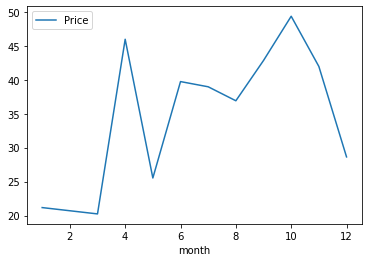

In [25]:
df_realtime.drop('year', axis=1, inplace=True)

df_realtime.groupby('month').mean().plot(legend=True)

/Users/michen/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<AxesSubplot:xlabel='month'>

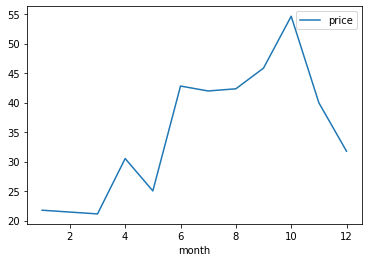

In [26]:
df_dam.drop('year', axis=1, inplace=True)

df_dam.groupby('month').mean().plot(legend=True)

In [27]:
df_price_ng = df_dam.groupby('month').mean().reset_index()

In [28]:
df_price_ng.head

<bound method NDFrame.head of     month      price
0       1  21.757325
1       3  21.130767
2       4  30.515000
3       5  25.030094
4       6  42.798667
5       7  41.966532
6       8  42.333952
7       9  45.837375
8      10  54.628831
9      11  39.964681
10     12  31.755916>

In [29]:
#https://www.eia.gov/dnav/ng/hist/rngwhhdm.htm
df_price_ng['natural_gas_price'] = [2.71, 2.62,2.66, 2.91, 3.26, 3.84, 4.07, 5.16, 5.51, 5.05, 3.6]

In [30]:
df_price_ng.columns

Index(['month', 'price', 'natural_gas_price'], dtype='object')

<AxesSubplot:title={'center':'2021 Monthly NG price'}, xlabel='month'>

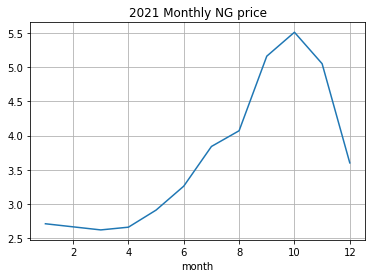

In [31]:
df_price_ng.plot(x ='month', y='natural_gas_price', kind = 'line', title="2021 Monthly NG price", 
                      grid=True, legend=False)

# Curtail for REAL TIME

In [32]:
df_realtime = df_realtime.rename(columns={'Price': 'price'})
df_realtime['SMA'] = df_realtime['price'].rolling(2).mean()

#df_realtime['SMA3'] = df_realtime['price'].rolling(3).mean()


                                           

****************************************************************************************************
Curtail at 50
           price        SMA
month                      
1      18.925039  18.964512
3      16.087755  16.128515
4      21.315553  21.273818
5      21.012660  20.984369
6      25.942371  25.878944
7      29.763062  29.737967
8      31.804636  31.834686
9      34.538915  34.493146
10     34.208149  34.186437
11     29.972374  30.136726
12     25.170121  25.226845
Overall Average  25.688481653155865
Uptime percentage  0.8631551768654789
****************************************************************************************************
Curtail at 55
           price        SMA
month                      
1      19.101106  19.196540
3      16.093833  16.183474
4      21.503773  21.516455
5      21.417906  21.294820
6      26.235980  26.176243
7      30.344013  30.341159
8      32.588015  32.590901
9      35.888750  35.916214
10     37.834008  37.805754
11     31.319585  31.345

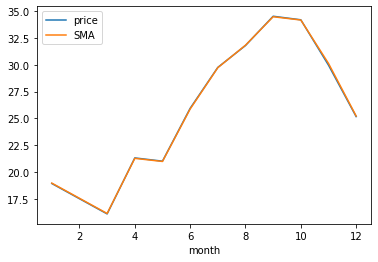

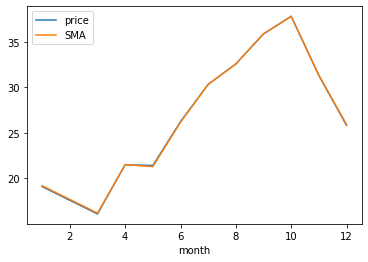

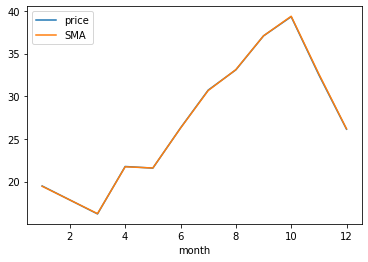

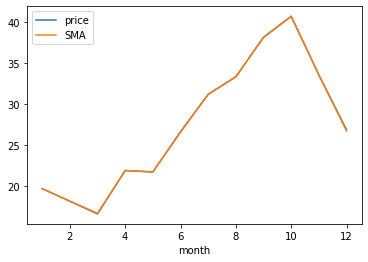

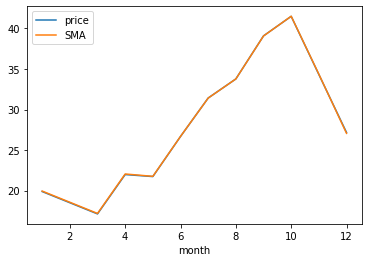

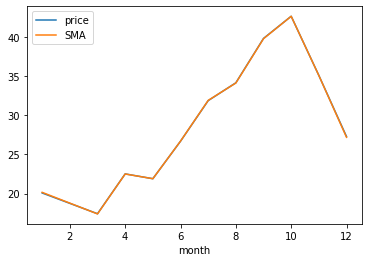

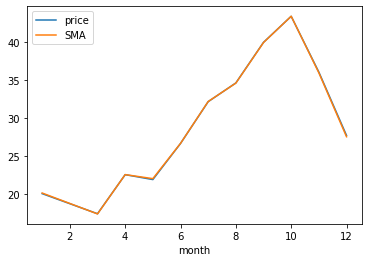

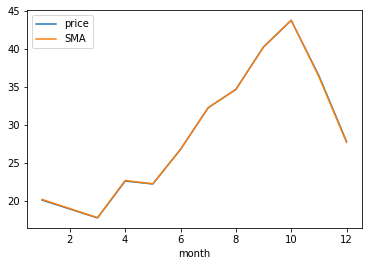

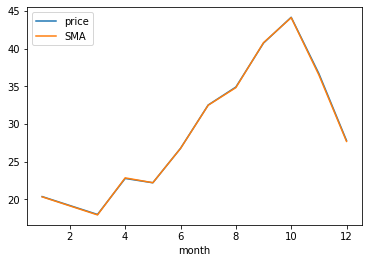

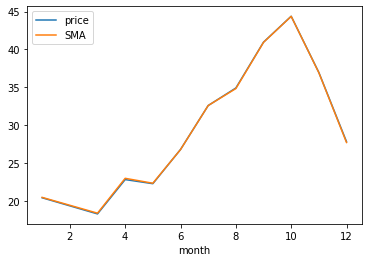

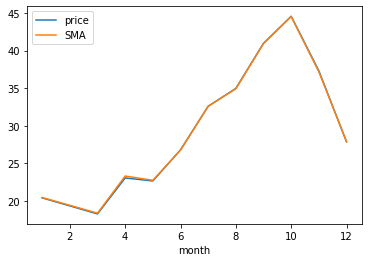

In [33]:
curtail_analysis = pd.DataFrame(columns = ['curtail', 'average', 'uptime'])

for curtail in range(50,105, 5):
    print("*"*100)
    print("Curtail at "+ str(curtail))
    df_curtail = df_realtime [df_realtime['SMA'] <= curtail]
    print(df_curtail.groupby('month').mean())
    df_curtail.groupby('month').mean().plot(legend=True)
    print("Overall Average ", df_curtail['price'].mean())
    print("Uptime percentage ", df_curtail['Date'].count()/df_realtime['Date'].count())
    curtail_analysis = curtail_analysis.append({'curtail' : curtail, 'average' :df_curtail['price'].mean(), 'uptime' : df_curtail['Date'].count()/df_realtime['Date'].count()}, 
                ignore_index = True)

In [34]:
curtail_analysis

,curtail,average,uptime
0,50.0,25.688482,0.863155
1,55.0,26.719277,0.898012
2,60.0,27.389826,0.918280
3,65.0,28.049149,0.935321
4,70.0,28.493619,0.946682
5,75.0,28.985138,0.956881
6,80.0,29.339935,0.964111
7,85.0,29.544892,0.967854
8,90.0,29.777635,0.971211
9,95.0,29.887528,0.973664


<AxesSubplot:title={'center':'Average after curtail'}, xlabel='curtail'>

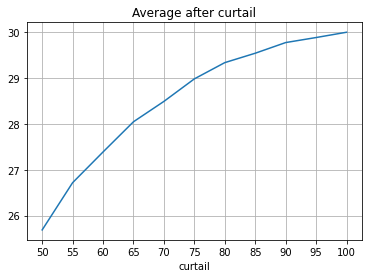

In [35]:
curtail_analysis.plot(x ='curtail', y='average', kind = 'line', title="Average after curtail", 
                      xticks=range(50,105,5),
                      grid=True, legend=False)


<AxesSubplot:title={'center':'Uptime after curtail'}, xlabel='curtail'>

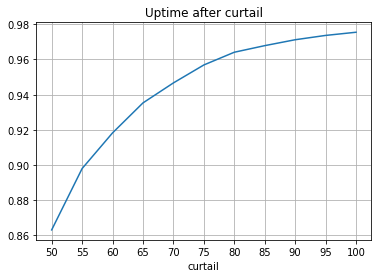

In [36]:
curtail_analysis.plot(x ='curtail', y='uptime', kind = 'line', title="Uptime after curtail", 
                      xticks=range(50,105,5),
                      #yticks=range(0.84,1.0,0.02),
                      grid=True, legend=False)

# Curtail for DAM

In [46]:
curtail_analysis.drop(curtail_analysis.index, inplace=True)

In [47]:
curtail_analysis.head

<bound method NDFrame.head of Empty DataFrame
Columns: [curtail, average, uptime]
Index: []>

****************************************************************************************************
Curtail at 50
           price
month           
1      21.251049
3      20.114455
4      23.295657
5      24.158306
6      27.224281
7      30.201244
8      31.929072
9      34.297750
10     38.795104
11     33.371073
12     28.685416
Overall Average  27.722591463414705
Uptime percentage  0.8467793984768297
****************************************************************************************************
Curtail at 55
           price
month           
1      21.424431
3      20.376881
4      23.698079
5      24.536277
6      27.775039
7      31.330233
8      33.213984
9      35.842653
10     40.070056
11     34.594797
12     29.245183
Overall Average  28.655699618656552
Uptime percentage  0.8800826126242416
****************************************************************************************************
Curtail at 60
           price
month           
1      21.569204
3      20.5771

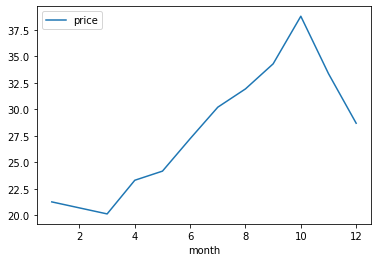

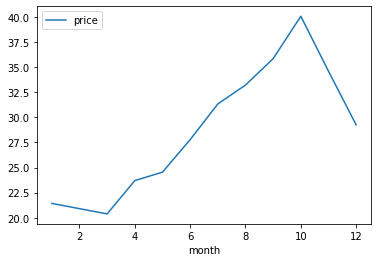

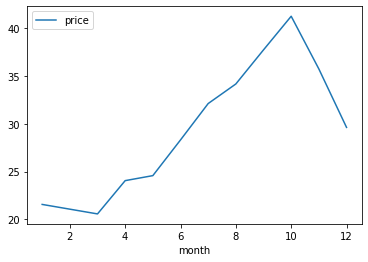

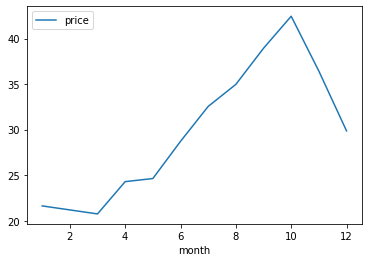

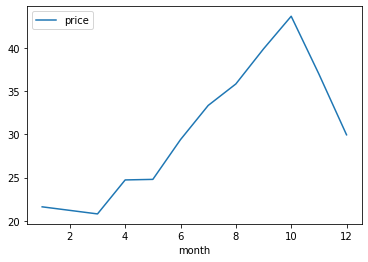

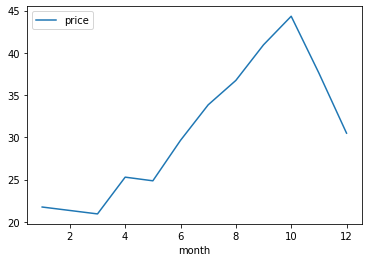

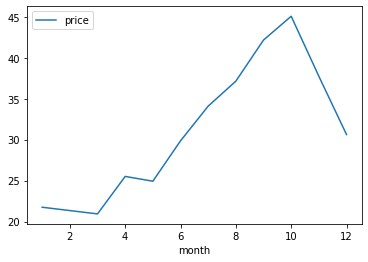

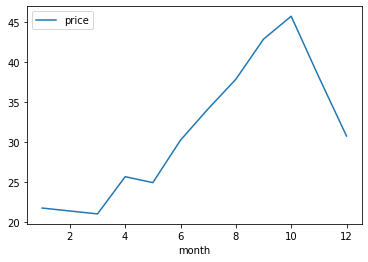

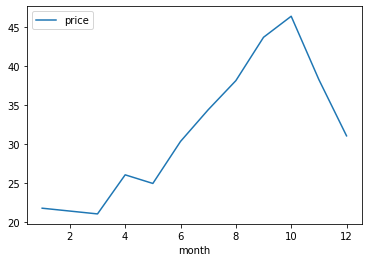

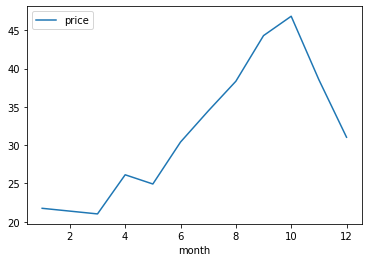

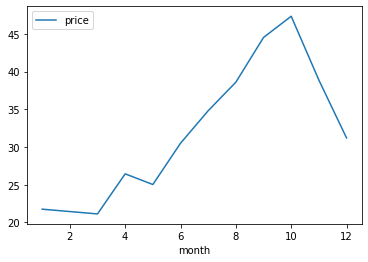

In [48]:

#pd.DataFrame(columns = ['curtail', 'average', 'uptime'])

for curtail in range(50,105, 5):
    print("*"*100)
    print("Curtail at "+ str(curtail))
    df_curtail = df_dam [df_dam['price'] <= curtail]
    print(df_curtail.groupby('month').mean())
    df_curtail.groupby('month').mean().plot(legend=True)
    print("Overall Average ", df_curtail['price'].mean())
    print("Uptime percentage ", df_curtail['Date'].count()/df_dam['Date'].count())
    curtail_analysis = curtail_analysis.append({'curtail' : curtail, 'average' :df_curtail['price'].mean(), 'uptime' : df_curtail['Date'].count()/df_dam['Date'].count()}, 
                ignore_index = True)
                                           

In [49]:
curtail_analysis

,curtail,average,uptime
0,50.0,27.722591,0.846779
1,55.0,28.655700,0.880083
2,60.0,29.464094,0.905770
3,65.0,30.070585,0.922938
4,70.0,30.696602,0.938686
5,75.0,31.238219,0.951078
6,80.0,31.596642,0.958565
7,85.0,31.942359,0.965148
8,90.0,32.235739,0.970311
9,95.0,32.444234,0.973667


<AxesSubplot:title={'center':'Average after curtail'}, xlabel='curtail'>

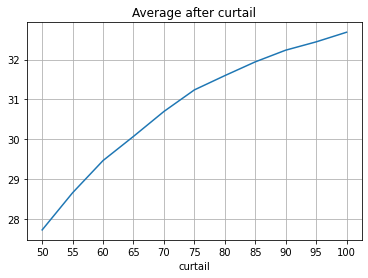

In [50]:
curtail_analysis.plot(x ='curtail', y='average', kind = 'line', title="Average after curtail", 
                      xticks=range(50,105,5),
                      grid=True, legend=False)


<AxesSubplot:title={'center':'Uptime after curtail'}, xlabel='curtail'>

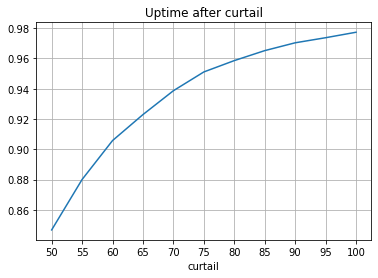

In [51]:
curtail_analysis.plot(x ='curtail', y='uptime', kind = 'line', title="Uptime after curtail", 
                      xticks=range(50,105,5),
                      #yticks=range(0.84,1.0,0.02),
                      grid=True, legend=False)
